### Importing Required Libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import shutil

### Specifying Image Size, Batch Size, Epochs, Channels

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras 
from keras import layers
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Create Files_Name
image_data='/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

Files_Name
0   pituitary
1     notumor
2  meningioma
3      glioma

In [3]:
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pan.DataFrame(data, columns = ["Image", "Label"])
dataframe

Image       Label
0     /kaggle/input/brain-mri-scans-for-brain-tumor-...     notumor
1     /kaggle/input/brain-mri-scans-for-brain-tumor-...     notumor
2     /kaggle/input/brain-mri-scans-for-brain-tumor-...      glioma
3     /kaggle/input/brain-mri-scans-for-brain-tumor-...   pituitary
4     /kaggle/input/brain-mri-scans-for-brain-tumor-...     notumor
...                                                 ...         ...
1306  /kaggle/input/brain-mri-scans-for-brain-tumor-...   pituitary
1307  /kaggle/input/brain-mri-scans-for-brain-tumor-...  meningioma
1308  /kaggle/input/brain-mri-scans-for-brain-tumor-...      glioma
1309  /kaggle/input/brain-mri-scans-for-brain-tumor-...     notumor
1310  /kaggle/input/brain-mri-scans-for-brain-tumor-...     notumor

[1311 rows x 2 columns]

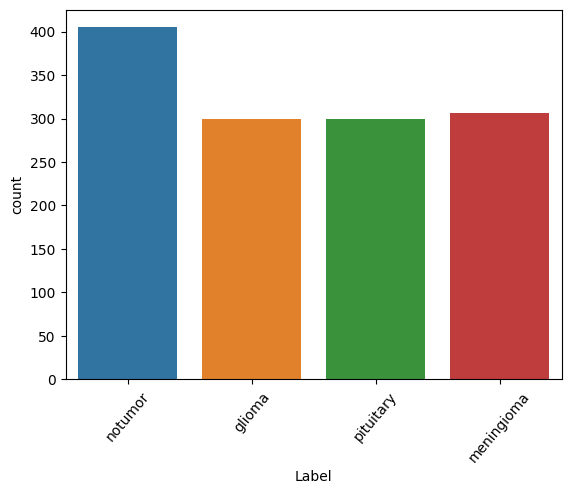

In [4]:
sns.countplot(x = dataframe["Label"])
plotter.xticks(rotation = 50);

In [5]:
Image_Size = 256
Batch_Size = 64
Channels = 3
Epochs = 50

### Loading Dataset

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/brain-mri-scans-for-brain-tumor-classification/data",
    shuffle = True,
    image_size = (Image_Size, Image_Size),
    batch_size = Batch_Size
)

Found 1311 files belonging to 4 classes.


### Class Names

In [7]:
classes = dataset.class_names
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

### Length of Dataset

In [8]:
len(dataset)

21

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[2 0 1 0 3 0 2 1 3 3 1 3 0 0 1 3 2 0 0 3 2 1 2 1 3 0 1 2 2 1 1 3 0 2 2 1 1
 3 1 2 3 0 1 3 0 1 3 3 2 1 1 2 0 1 1 2 2 0 0 2 0 2 2 3]


### Data Visualization

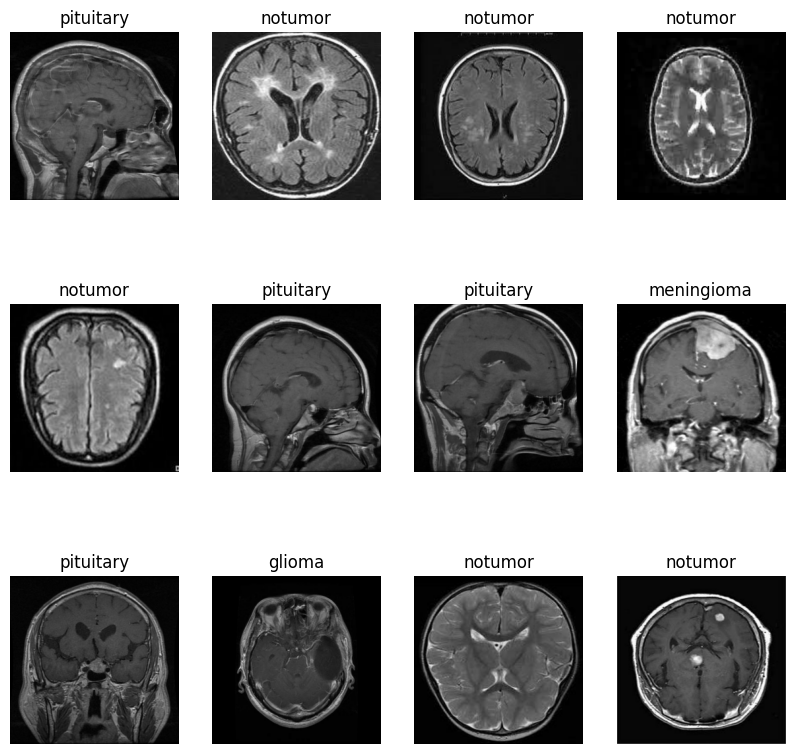

In [10]:
plt.figure(num=10, figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

### Train Test Split - 

80% --> Training, 10% --> Validation, 10% --> Testing 

In [11]:
def dataset_get_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = dataset_get_partitions_tf(dataset)

In [13]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

16
2
3


### Shuffling Data

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Resize and Rescale Layer

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation Layer

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Building

In [17]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(4, activation='softmax')
])

### Model Summary

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)       

### Setting up Learning Rate and Optimizer

In [19]:
# Implement learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### Compiling the Model

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

### Setting up Early Stopping

In [21]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

### Training Model

In [22]:
# Train the model with more epochs
history = model.fit(
    train_ds,
    epochs=Epochs,  # Increase the number of epochs
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
16/16 [==============================] - 14s 190ms/step - loss: 7.9732 - accuracy: 0.3086 - val_loss: 1.3568 - val_accuracy: 0.3438
Epoch 2/50
16/16 [==============================] - 1s 68ms/step - loss: 1.1583 - accuracy: 0.5029 - val_loss: 1.0487 - val_accuracy: 0.5000
Epoch 3/50
16/16 [==============================] - 1s 64ms/step - loss: 0.8960 - accuracy: 0.6162 - val_loss: 0.8461 - val_accuracy: 0.6562
Epoch 4/50
16/16 [==============================] - 1s 65ms/step - loss: 0.7110 - accuracy: 0.7334 - val_loss: 0.7005 - val_accuracy: 0.7266
Epoch 5/50
16/16 [==============================] - 1s 64ms/step - loss: 0.5871 - accuracy: 0.7568 - val_loss: 0.6108 - val_accuracy: 0.7422
Epoch 6/50
16/16 [==============================] - 1s 64ms/step - loss: 0.5073 - accuracy: 0.8115 - val_loss: 0.5522 - val_accuracy: 0.7812
Epoch 7/50
16/16 [==============================] - 1s 64ms/step - loss: 0.4530 - accuracy: 0.8223 - val_loss: 0.5126 - val_accuracy: 0.7891
Epoch 8/50


### Evaluating Model on test data

In [23]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 2s 27ms/step - loss: 0.2417 - accuracy: 0.9167


### Plotting Loss and Accuracy Curve

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

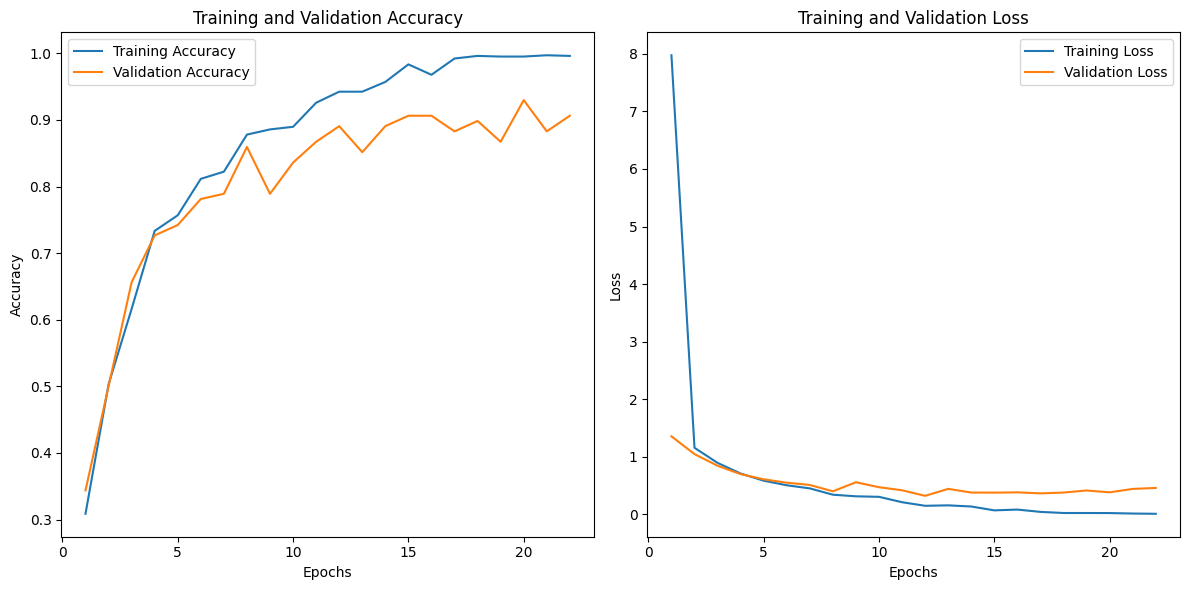

In [25]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Looking at Predictions

2/2 [==============================] - 1s 11ms/step


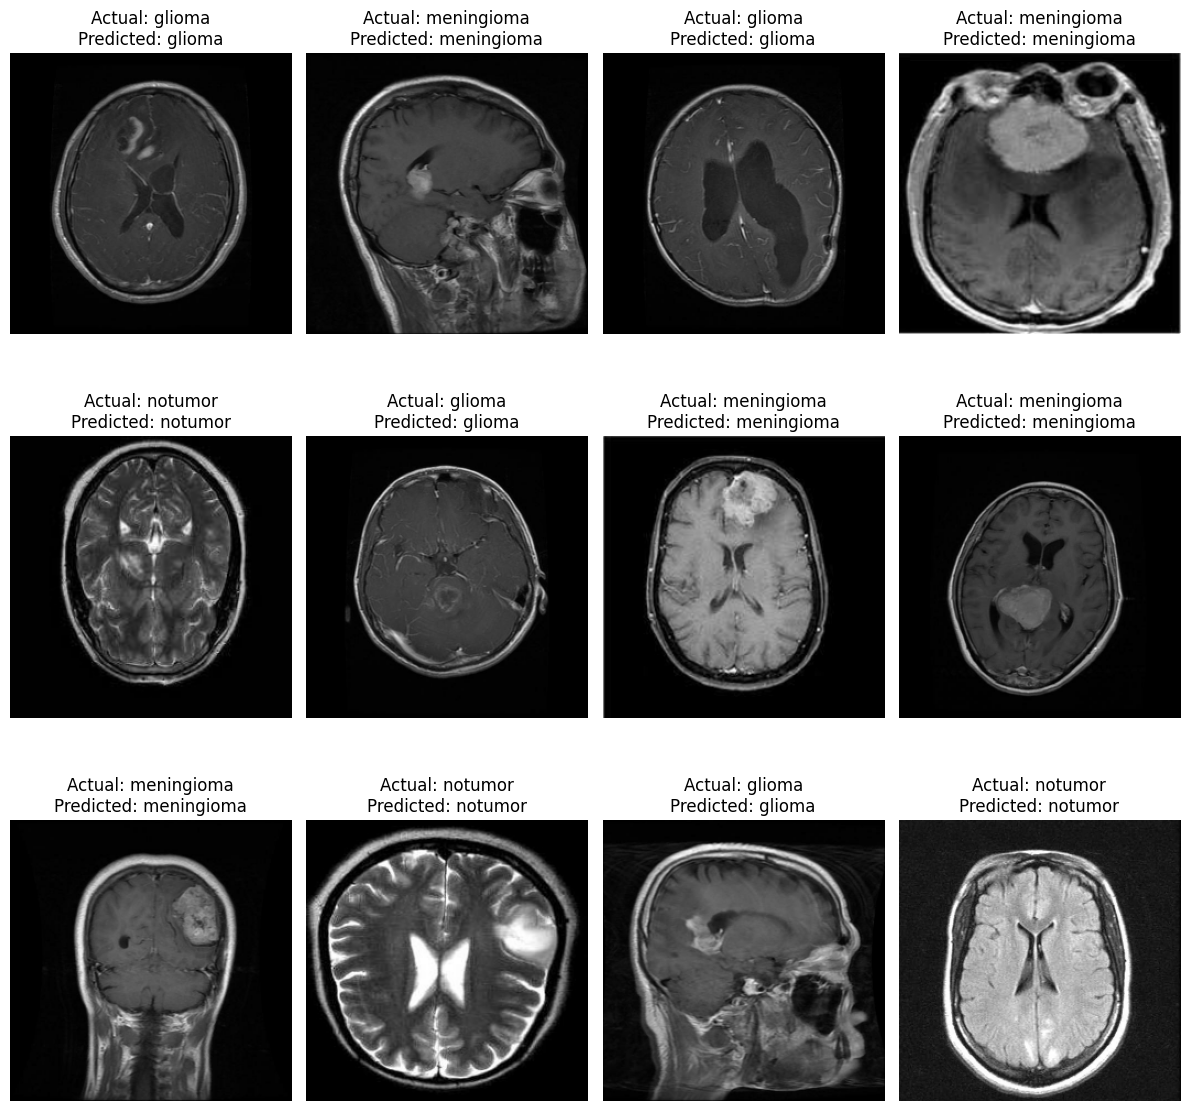

In [26]:
# Get some random samples from the test dataset
sample_images = []
sample_labels = []
for images, labels in test_ds.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()

# Make predictions on the random samples
predictions = model.predict(sample_images)

# Visualize random samples with actual and predicted labels
num_samples = len(sample_images)
num_rows = 3
num_cols = 4
plt.figure(figsize=(12, 12))
for i in range(min(num_samples, num_rows * num_cols)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    actual_label = classes[sample_labels[i]]
    predicted_label = classes[np.argmax(predictions[i])]
    title = f"Actual: {actual_label}\nPredicted: {predicted_label}"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Another Approach

In [27]:
train_data_dir =image_data
batch_size = 32
target_size = (224,224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

Found 1311 files belonging to 4 classes.
Using 1049 files for training.
Found 1311 files belonging to 4 classes.
Using 262 files for validation.


In [28]:
class_names = train.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

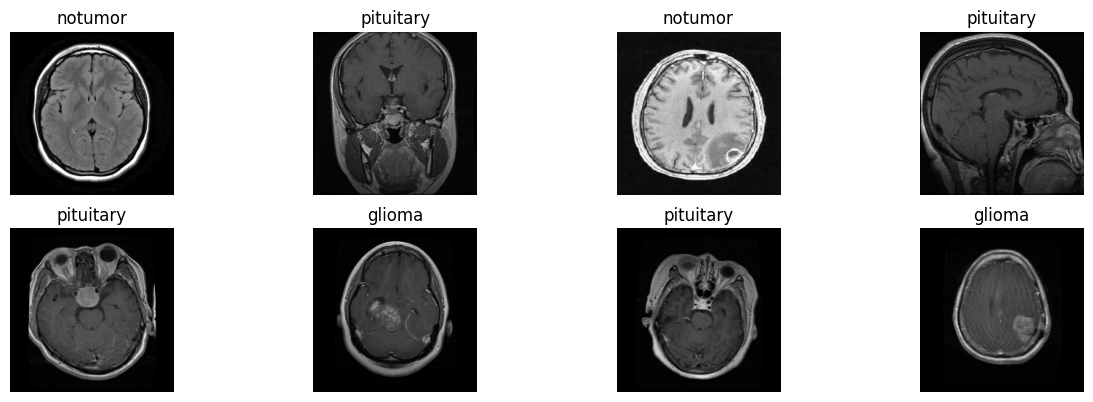

In [29]:
plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [30]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten()) 
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(4,activation=tf.nn.softmax))
keras_model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 28224)             0         
                                                                 
 dropout (Dropout)           (None, 28224)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 112900    
                                                                 
Total params: 1052020 (4.01 MB)
Trainable params: 112900 (441.02 KB)
Non-trainable params: 939120 (3.58 MB)
_________________________________________________________________


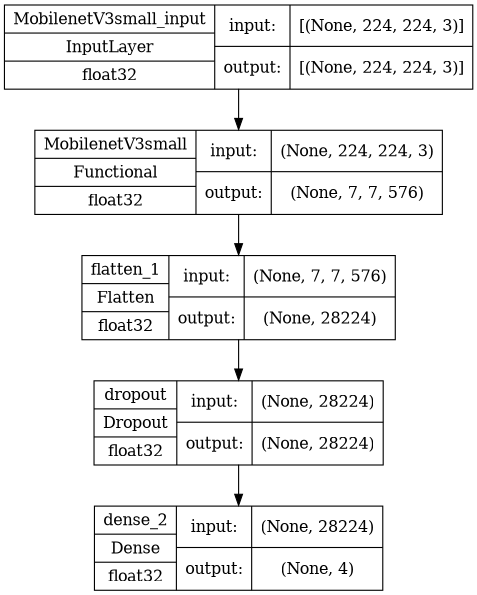

In [31]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [32]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping =EarlyStopping(patience=5, restore_best_weights=True)
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=keras_model.fit_generator(train,epochs=20,validation_data=validation,callbacks=[checkpoint,early_stopping])


Epoch 1/20
33/33 [==============================] - 8s 117ms/step - loss: 1.9008 - accuracy: 0.7045 - val_loss: 0.4652 - val_accuracy: 0.9084
Epoch 2/20
33/33 [==============================] - 2s 51ms/step - loss: 0.6056 - accuracy: 0.8913 - val_loss: 0.1774 - val_accuracy: 0.9389
Epoch 3/20
33/33 [==============================] - 2s 51ms/step - loss: 0.3271 - accuracy: 0.9295 - val_loss: 0.1089 - val_accuracy: 0.9809
Epoch 4/20
33/33 [==============================] - 2s 43ms/step - loss: 0.1585 - accuracy: 0.9590 - val_loss: 0.1169 - val_accuracy: 0.9733
Epoch 5/20
33/33 [==============================] - 2s 51ms/step - loss: 0.1025 - accuracy: 0.9771 - val_loss: 0.0812 - val_accuracy: 0.9885
Epoch 6/20
33/33 [==============================] - 2s 50ms/step - loss: 0.0576 - accuracy: 0.9819 - val_loss: 0.0768 - val_accuracy: 0.9924
Epoch 7/20
33/33 [==============================] - 2s 42ms/step - loss: 0.0875 - accuracy: 0.9790 - val_loss: 0.0893 - val_accuracy: 0.9847
Epoch 8/20
3

In [33]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)
hist_=pd.DataFrame(hist.history)
hist_

9/9 [==============================] - 0s 20ms/step - loss: 0.0488 - accuracy: 0.9962
Test Loss = 0.04877724498510361
Test Accuracy = 0.9961832165718079


loss  accuracy  val_loss  val_accuracy
0   1.900773  0.704480  0.465211      0.908397
1   0.605574  0.891325  0.177420      0.938931
2   0.327089  0.929457  0.108854      0.980916
3   0.158506  0.959009  0.116887      0.973282
4   0.102482  0.977121  0.081242      0.988550
5   0.057643  0.981888  0.076766      0.992366
6   0.087543  0.979028  0.089267      0.984733
7   0.087545  0.982841  0.048578      0.992366
8   0.048434  0.988561  0.029699      0.992366
9   0.043355  0.984747  0.044688      0.992366
10  0.034041  0.986654  0.053408      0.992366
11  0.057223  0.985701  0.093964      0.984733
12  0.039560  0.987607  0.063438      0.984733
13  0.035940  0.987607  0.028988      0.996183
14  0.054167  0.986654  0.041037      0.996183
15  0.057336  0.983794  0.026429      0.992366
16  0.053702  0.989514  0.026857      0.996183
17  0.041779  0.988561  0.041819      0.996183
18  0.064472  0.986654  0.058716      0.996183
19  0.043578  0.990467  0.048777      0.996183

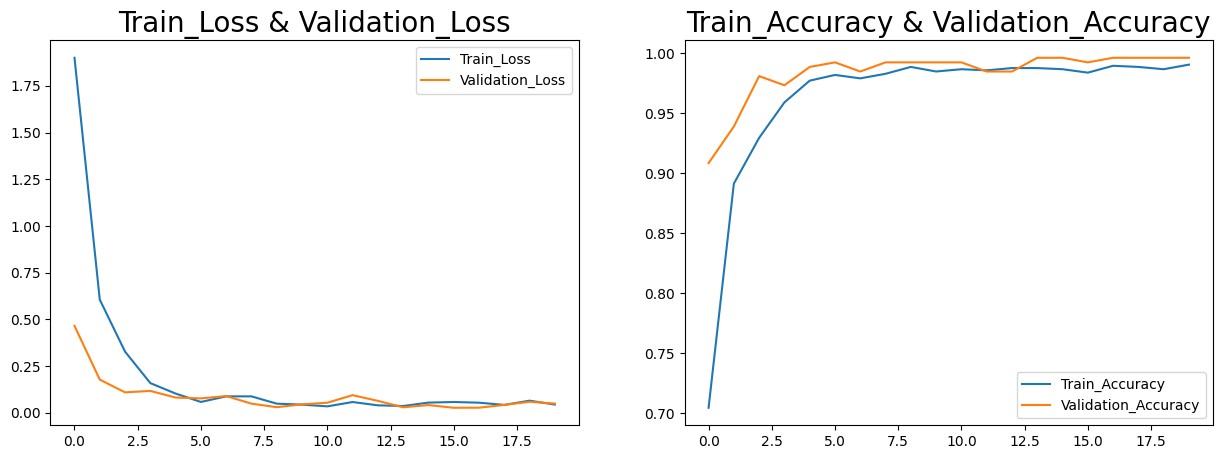

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()


In [35]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

9/9 [==============================] - 1s 23ms/step


Actual  Prediction
0         3           3
1         0           0
2         3           3
3         3           3
4         0           0
..      ...         ...
257       3           3
258       0           0
259       1           1
260       2           2
261       1           1

[262 rows x 2 columns]

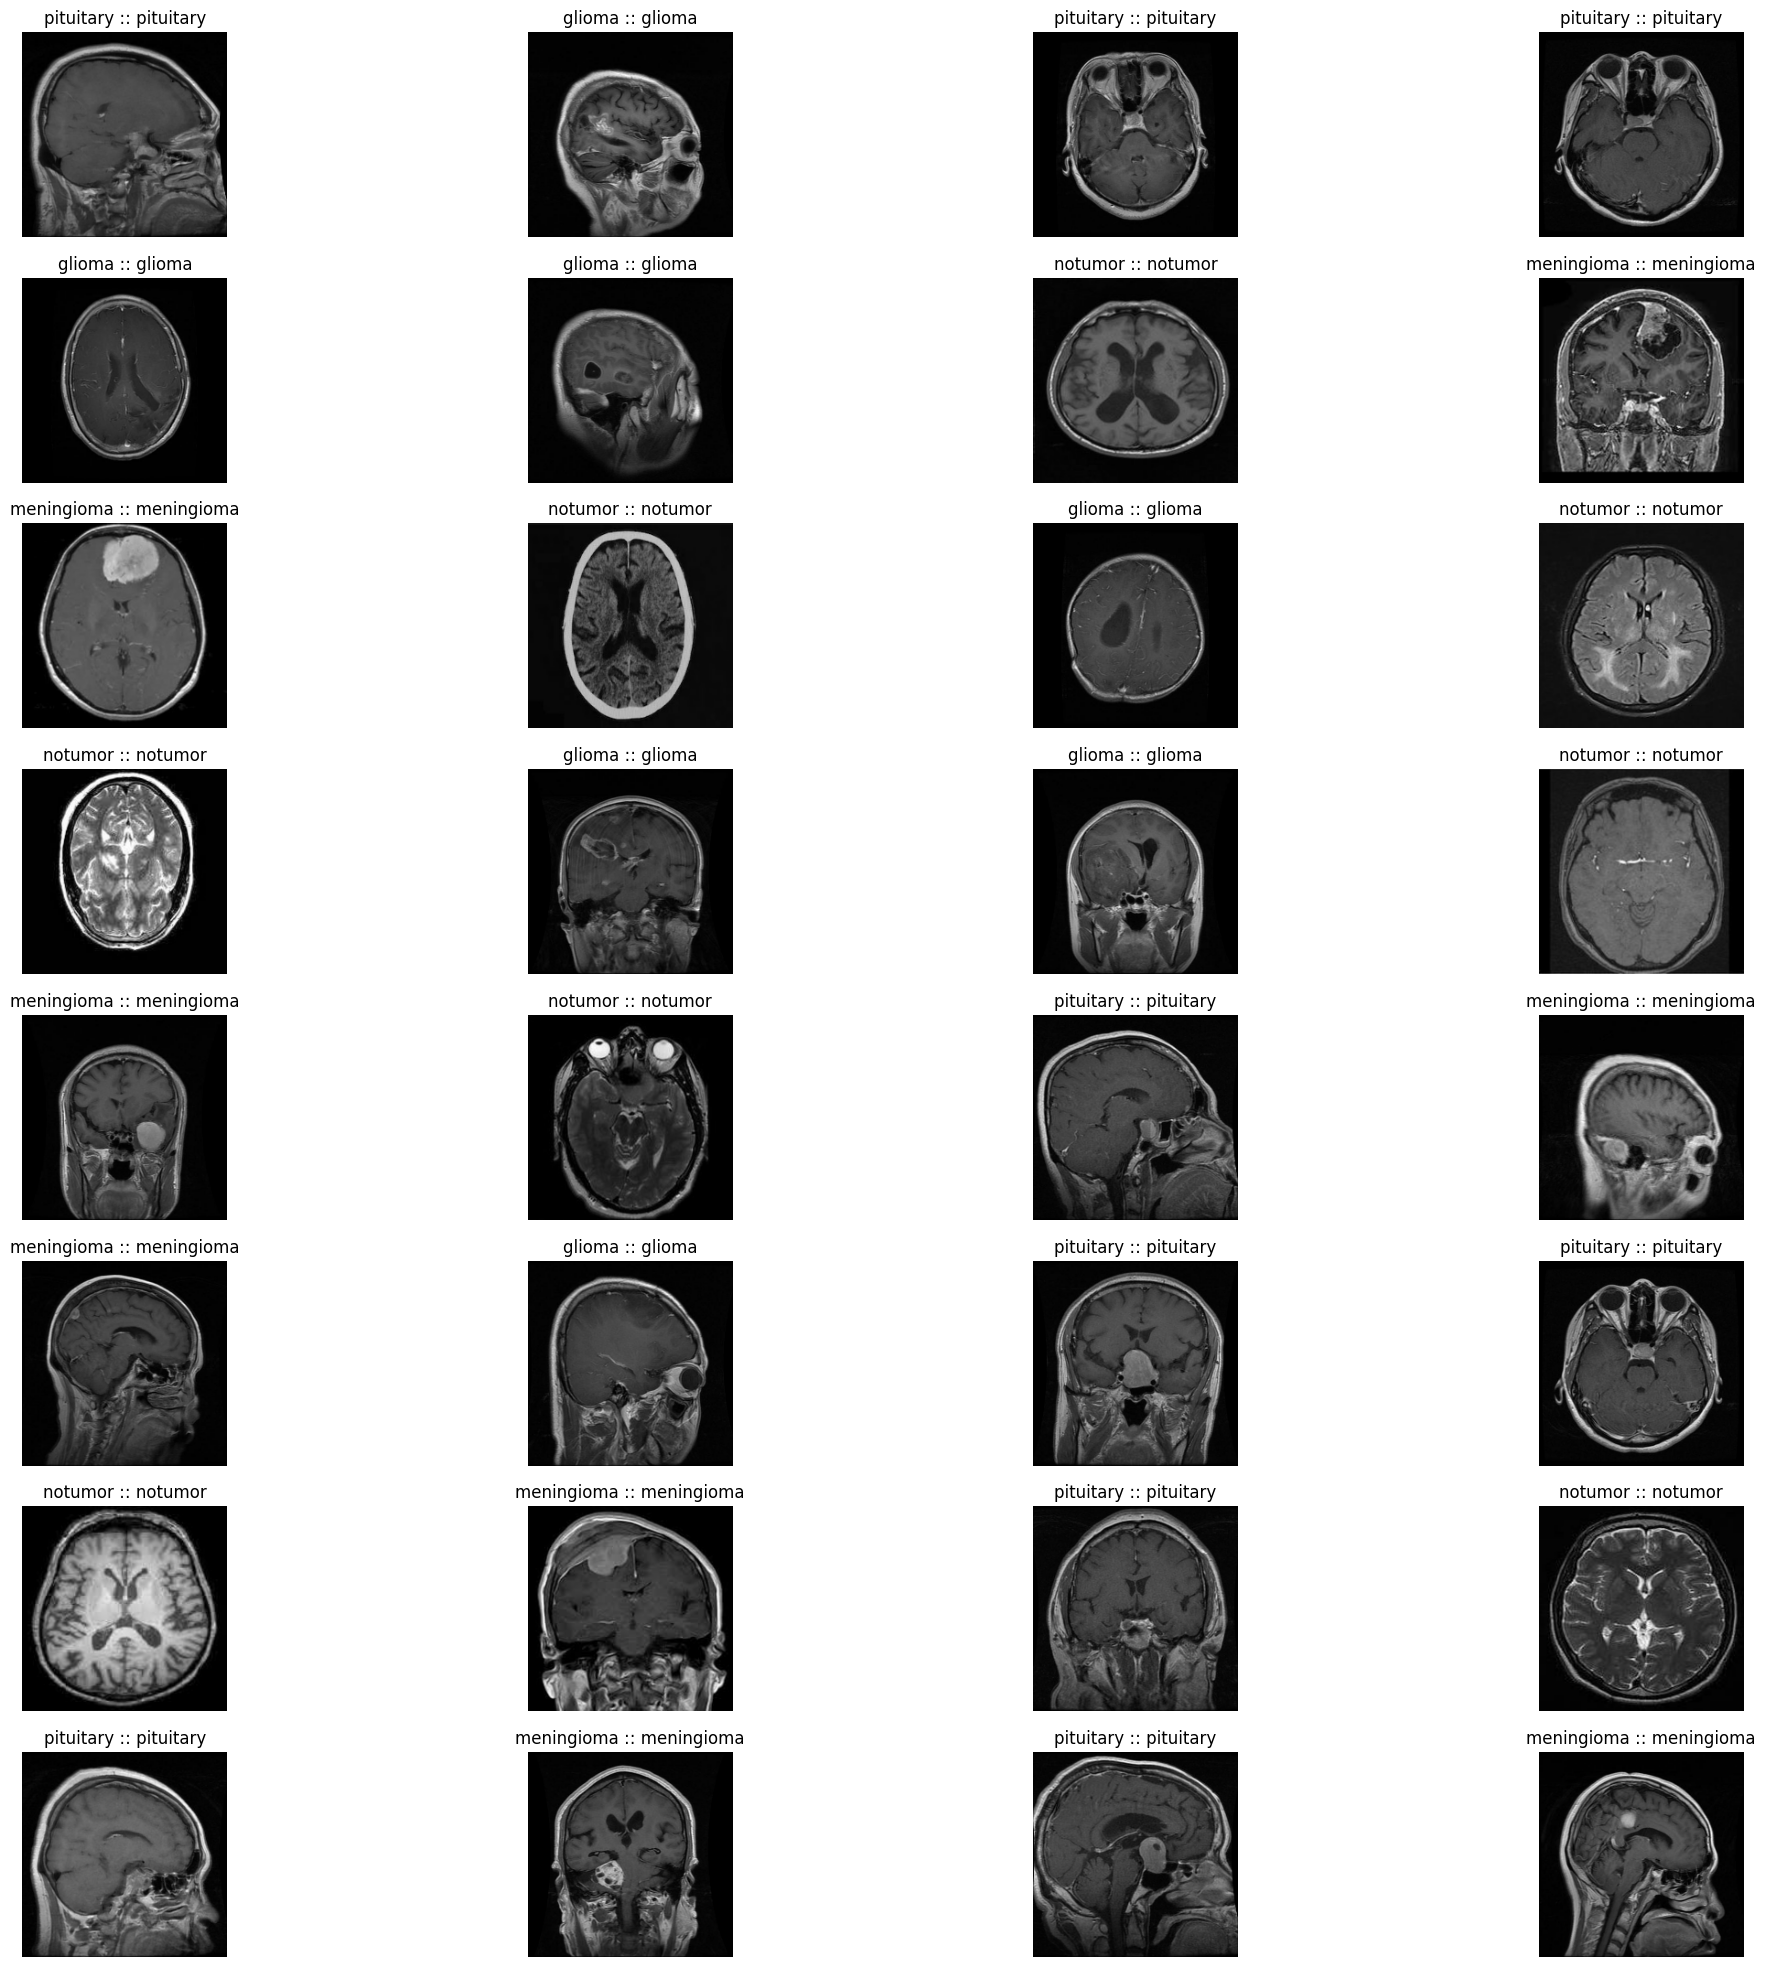

In [36]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

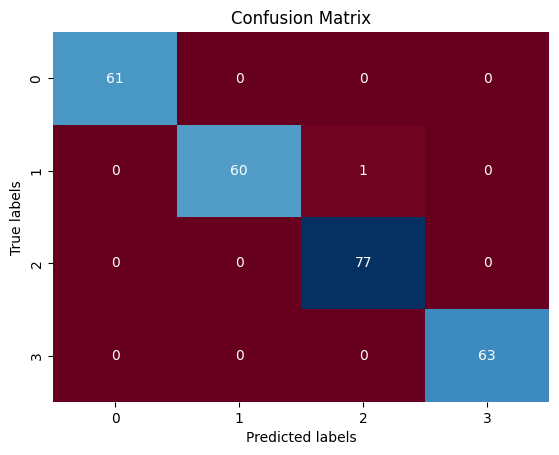

array([[61,  0,  0,  0],
       [ 0, 60,  1,  0],
       [ 0,  0, 77,  0],
       [ 0,  0,  0, 63]])

In [37]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [38]:
Acc = accuracy_score(y_val,y_pred)
print("accuracy is: {0:.3f}%".format(Acc * 100))

accuracy is: 99.618%


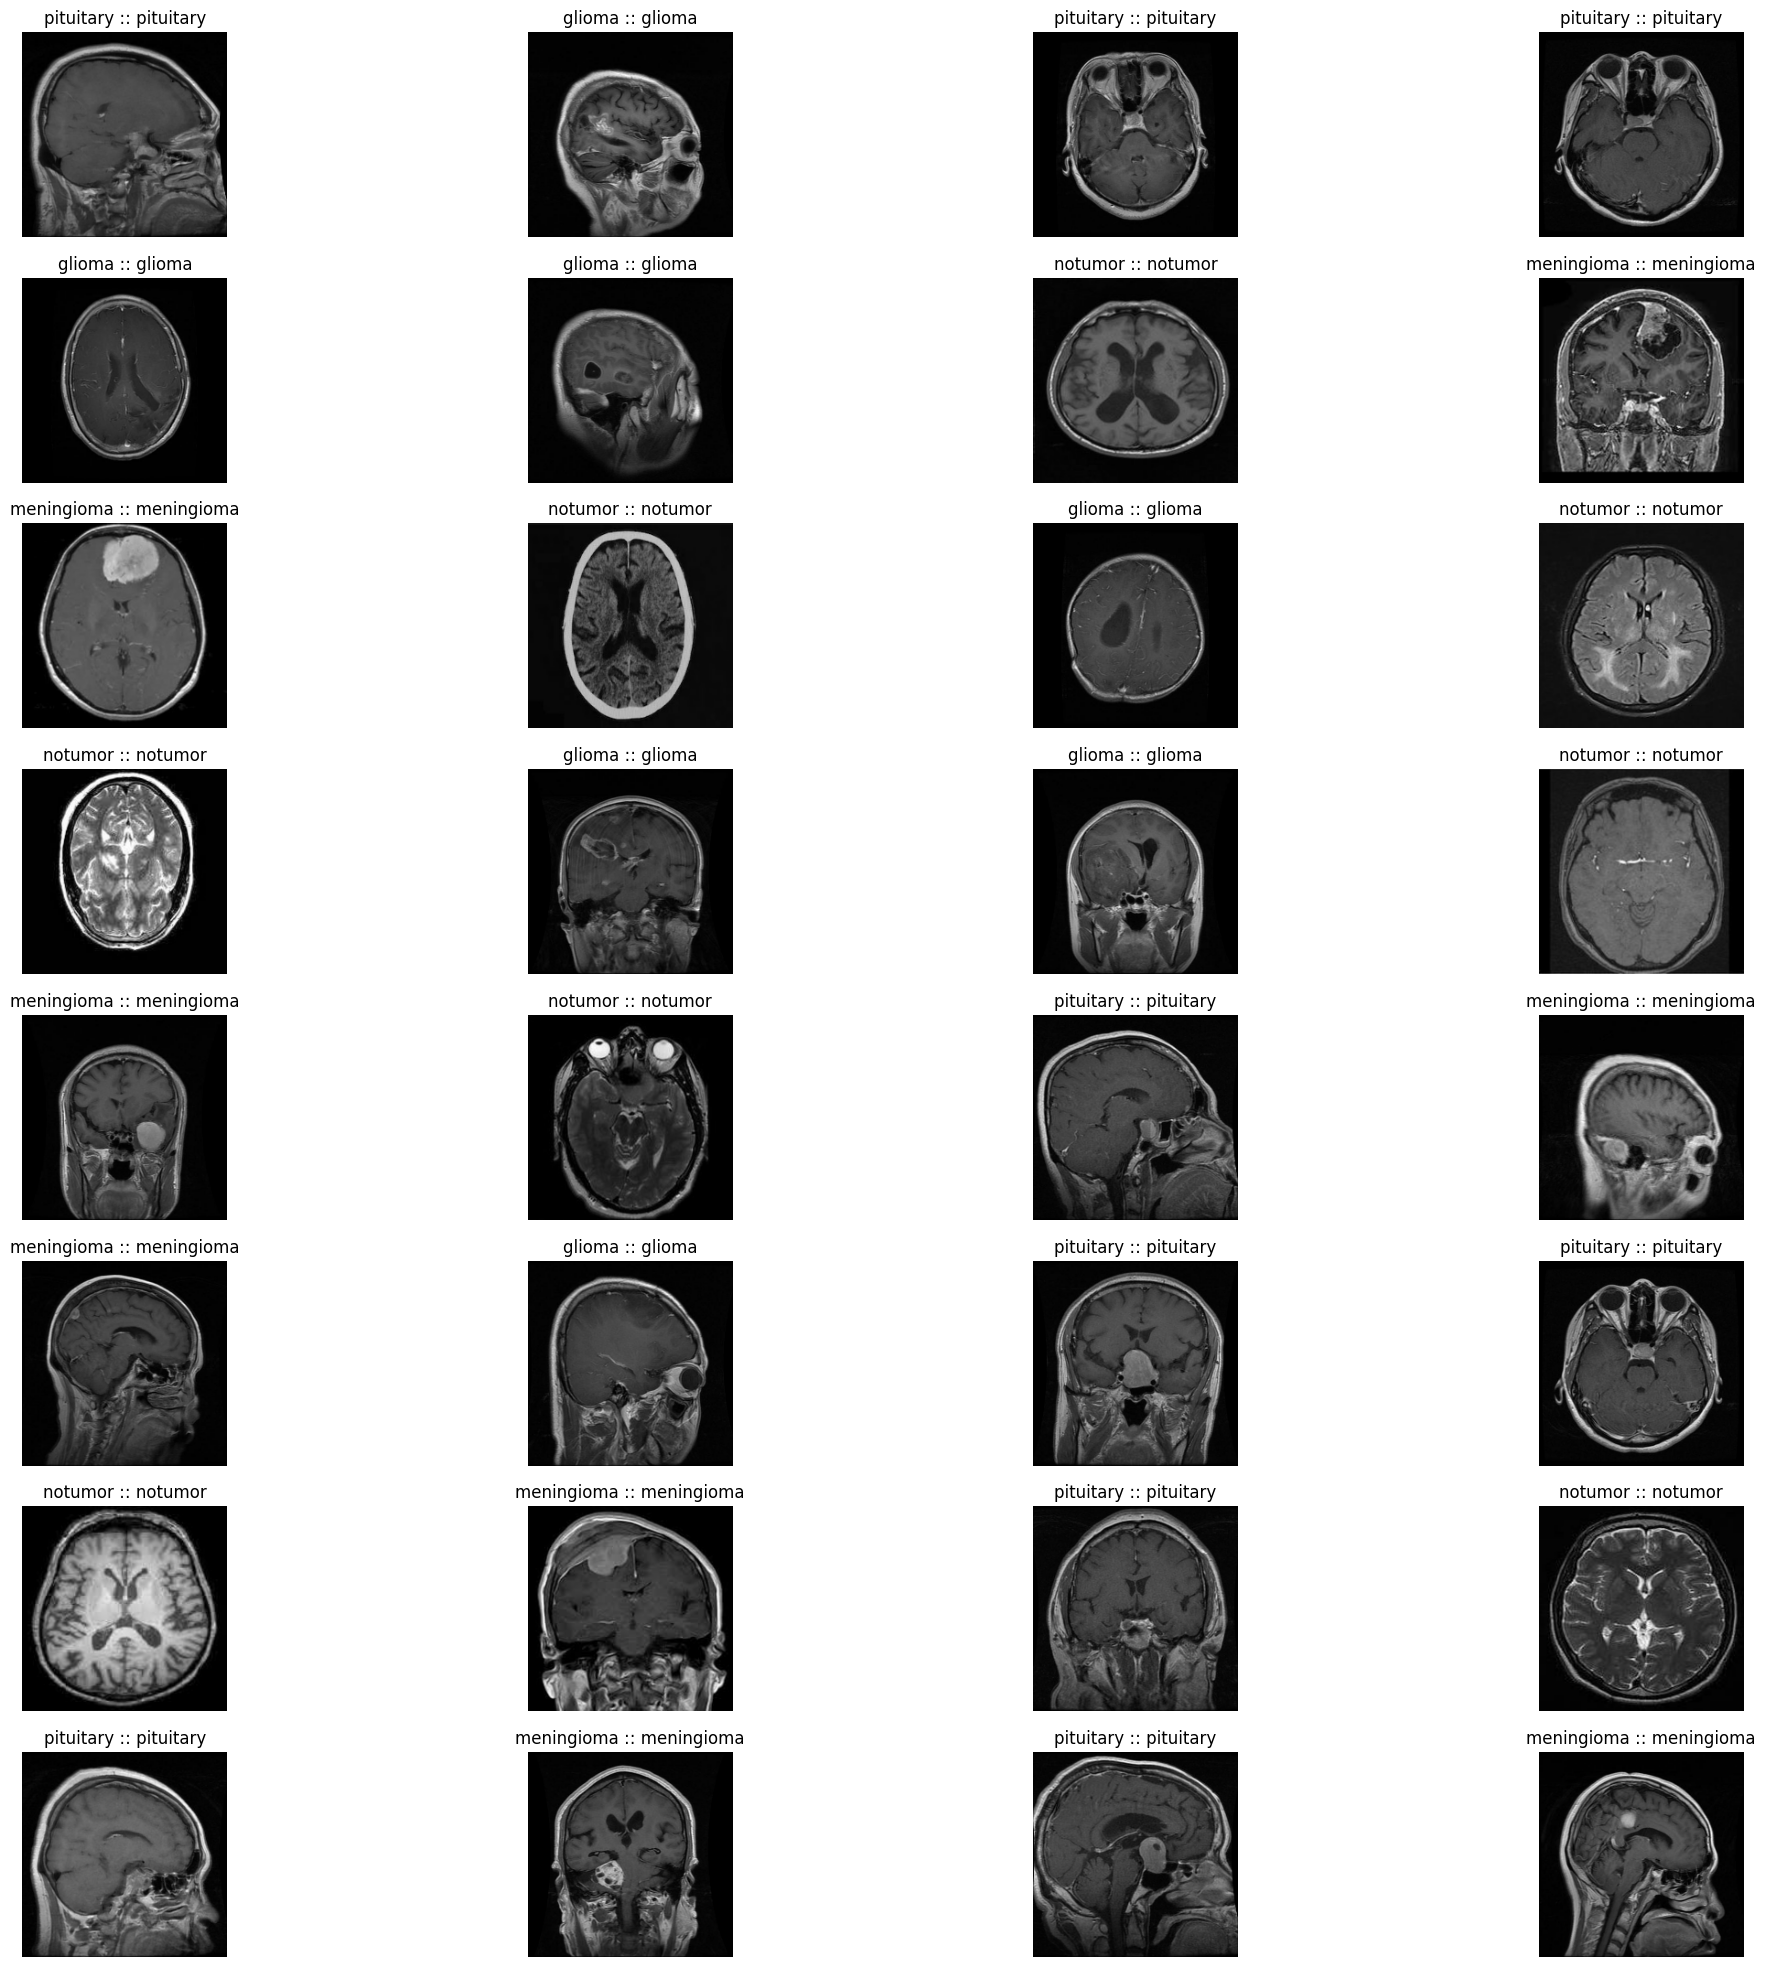

In [39]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")